# Set up and load our data

In [61]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt


# remove bad images

In [62]:
import imghdr

In [63]:
data_dir = 'data'

In [64]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [65]:
print(os.listdir(data_dir))

['kittens', 'puppies']


In [66]:
ds_store = '.DS_Store'
for img_class in os.listdir(data_dir):
    img_class_path = os.path.join(data_dir, img_class)
    if img_class == ds_store:
        os.remove(img_class_path)
        print(f'successfully removed {img_class}')
    else:
        continue

In [67]:
print(os.listdir(data_dir))

['kittens', 'puppies']


In [68]:
for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, img)
        try:
            img = cv2.imread(img_path)
            tip = imghdr.what(img_path)
            if tip not in img_exts:
                print('Image not in exts list {}'.format(img_path))
                os.remove(img_path)
        except Exception as e:
            print('Issue with image {}'.format(img_path))

In [69]:
os.listdir(data_dir)

['kittens', 'puppies']

In [70]:
import numpy as np

In [71]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 154 files belonging to 2 classes.


In [72]:
data_iterator = data.as_numpy_iterator()

2023-08-27 23:02:17.130660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]
2023-08-27 23:02:17.131260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]


In [73]:
#get another batch from iterator
batch = data_iterator.next()

In [74]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [75]:
# Class 0 = kittens
# Class 1 = puppies
batch[1]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

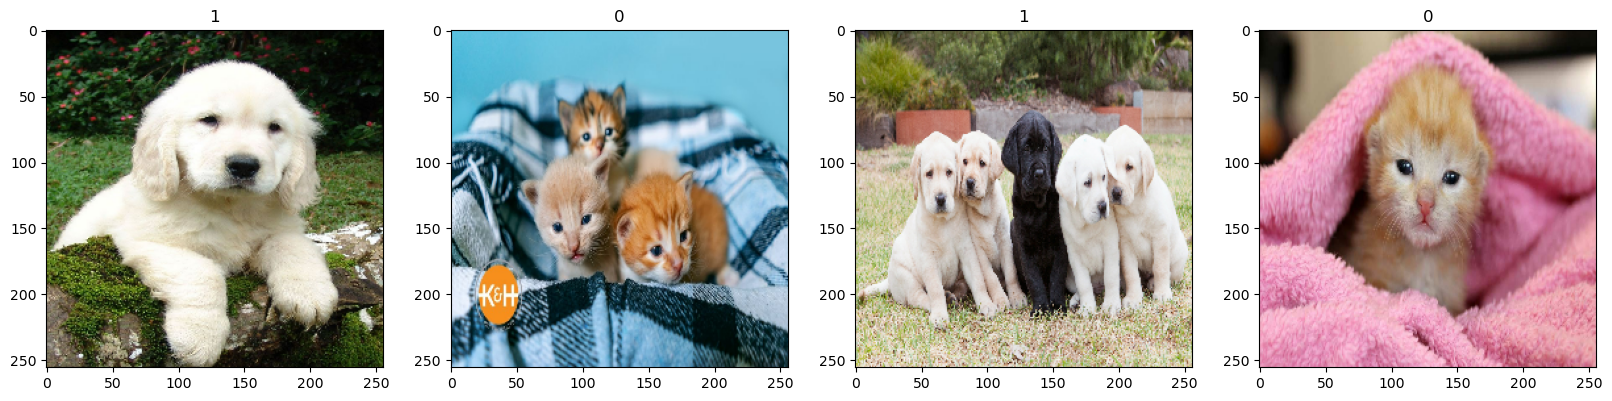

In [76]:
#0 = kittens
#1 = puppies
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [77]:
#scale image values to be between 0-1, instead of 0-255 (helps with optimization)
#split into train, test, validation to prevent overfitting

# preprocess data

### scale images

In [78]:
# x represents images
# y is target variable
data = data.map(lambda x, y: (x/255, y))

In [79]:
scaled_iterator = data.as_numpy_iterator()

2023-08-27 23:02:31.174425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]
2023-08-27 23:02:31.174967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]


In [80]:
batch = scaled_iterator.next()

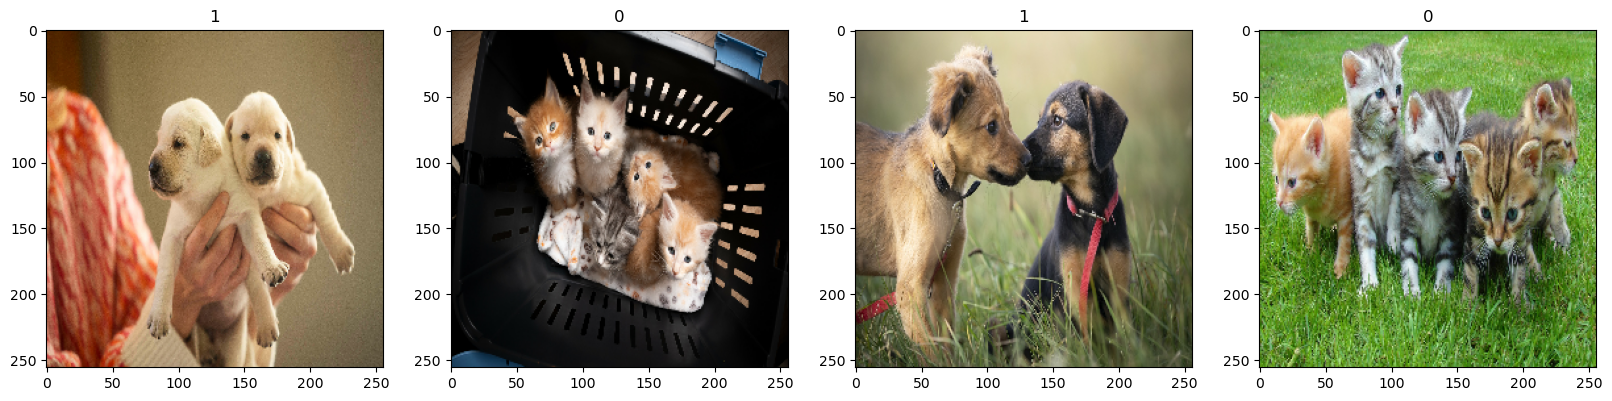

In [81]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### split data

In [82]:
len(data)

5

In [85]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [90]:
#skip the batches that are already in our training partition
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [93]:
len(test)

1

# deep model

### build

In [95]:
from tensorflow.keras.models import Sequential #one data input, one data output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [96]:
model = Sequential() #instantiate

In [99]:
#first layer is an input layer, a convolution
#16 filters, runs through it 16 times
#filter is 3x3 size
#stride=1, means itll look at 1 pixel at a time
#activation is ReLU activation, relu allows us to take into account non linear patterns
#input shape 256pixels, 256 pixels, 3 channels deep (colored)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3))) 
model.add(MaxPooling2D()) #take the maximum value after the activation and return that value

model.add(Conv2D(32, (3,3), 1, activation='relu')) #convolution block
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#flatten the data down, filters are last channel, #filters form channel value
#we dont want channel valye, we want one number
model.add(Flatten()) 

model.add(Dense(256, activation='relu')) #fully connected layer, 256 neurons
model.add(Dense(1, activation='sigmoid')) #1 = single output (0)


In [101]:
#adam optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [102]:
#max pooling, bc we have (2,2) halves the output
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [103]:
logdir='logs'

In [104]:
#save model at a checkpoint, specify logs to see how your model performed
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [105]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-08-27 23:38:21.163762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]
2023-08-27 23:38:21.164255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]


3/3 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.4167

2023-08-27 23:38:26.016137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]
2023-08-27 23:38:26.016991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]


3/3 [==============================] - 7s 2s/step - loss: 0.7052 - accuracy: 0.4167 - val_loss: 0.6887 - val_accuracy: 0.5312
Epoch 2/20
3/3 [==============================] - 5s 1s/step - loss: 0.6882 - accuracy: 0.5104 - val_loss: 0.6979 - val_accuracy: 0.4688
Epoch 3/20
3/3 [==============================] - 5s 1s/step - loss: 0.6836 - accuracy: 0.5521 - val_loss: 0.6286 - val_accuracy: 0.6875
Epoch 4/20
3/3 [==============================] - 5s 1s/step - loss: 0.6813 - accuracy: 0.5521 - val_loss: 0.6769 - val_accuracy: 0.5625
Epoch 5/20
3/3 [==============================] - 5s 1s/step - loss: 0.6683 - accuracy: 0.5625 - val_loss: 0.6632 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 5s 1s/step - loss: 0.6733 - accuracy: 0.5417 - val_loss: 0.6597 - val_accuracy: 0.6562
Epoch 7/20
3/3 [==============================] - 5s 1s/step - loss: 0.6663 - accuracy: 0.5938 - val_loss: 0.5968 - val_accuracy: 0.7812
Epoch 8/20
3/3 [==============================] - 5s

In [106]:
hist.history

{'loss': [0.7052168846130371,
  0.6881784796714783,
  0.6835748553276062,
  0.6813432574272156,
  0.6683385968208313,
  0.6732719540596008,
  0.6662885546684265,
  0.6468179821968079,
  0.6852884292602539,
  0.6107625365257263,
  0.5873619914054871,
  0.5769933462142944,
  0.5481168627738953,
  0.5652225017547607,
  0.4664078652858734,
  0.4417397677898407,
  0.5308388471603394,
  0.5389840602874756,
  0.392273873090744,
  0.47094133496284485],
 'accuracy': [0.4166666567325592,
  0.5104166865348816,
  0.5520833134651184,
  0.5520833134651184,
  0.5625,
  0.5416666865348816,
  0.59375,
  0.6041666865348816,
  0.5625,
  0.65625,
  0.6145833134651184,
  0.6979166865348816,
  0.7708333134651184,
  0.6875,
  0.7604166865348816,
  0.7916666865348816,
  0.7604166865348816,
  0.71875,
  0.8020833134651184,
  0.7708333134651184],
 'val_loss': [0.6886646747589111,
  0.6978670954704285,
  0.6286215782165527,
  0.6769030094146729,
  0.663200318813324,
  0.6597004532814026,
  0.5967679023742676,
  

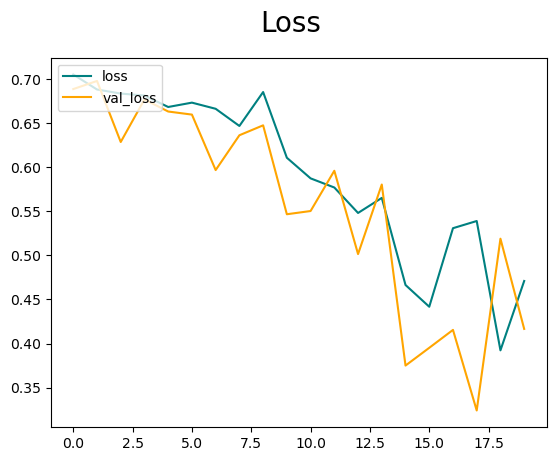

In [107]:
#if val loss is going up but loss is going down, sign of overfitting

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

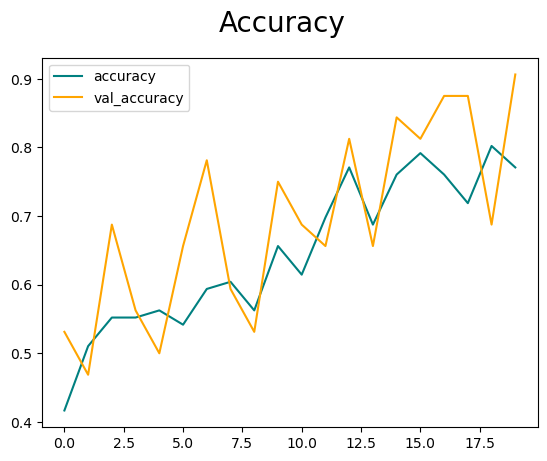

In [109]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# evaluation

In [110]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [111]:
pre = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [113]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X) #predictions between 0,1 because of sigmoid
    pre.update_state(y, yhat) #update metrics with update state
    recall.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-08-27 23:53:38.035045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [154]
	 [[{{node Placeholder/_0}}]]
2023-08-27 23:53:38.035548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [154]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 289ms/step


In [114]:
#numbers will be between 0, 1, 
#higher values on all means that the model is performing well

print(f'Precision:{pre.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.5263158082962036, Recall:1.0, Accuracy:0.6538461446762085


# test
test on an image never seen before

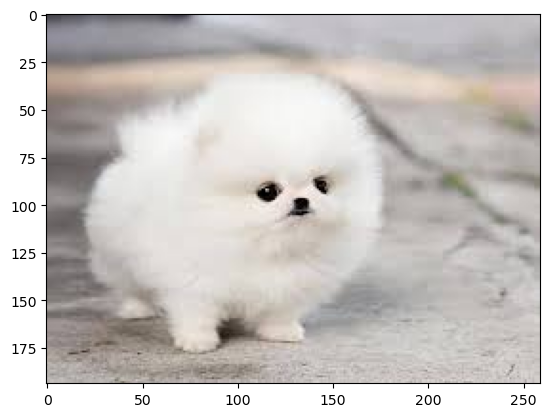

In [140]:
#kitten test
img = cv2.imread('puppy_test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

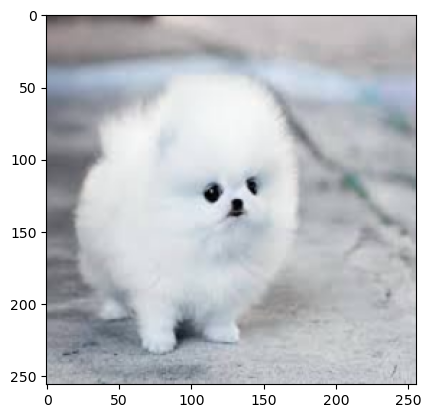

In [141]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [142]:
#model expects a batch, not a single image, this call puts into a tensor?
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [143]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [144]:
yhat

array([[0.65389735]], dtype=float32)

In [145]:
if yhat > 0.5:
    print(f"Predicted class is Puppy")
else:
    print(f"Predicted class is Kitten")

Predicted class is Puppy


In [146]:
from tensorflow.keras.models import load_model

In [147]:
model.save(os.path.join('models', 'kittenpuppy1model.h5'))

In [148]:
new_model1 = load_model(os.path.join('models', 'kittenpuppy1model.h5'))

In [149]:
new_model1

In [150]:
new_model1.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 114ms/step


array([[0.65389735]], dtype=float32)